Python: 3.10.18 | OS: Windows 10
numpy: 2.2.6 | pandas: 2.3.1
matplotlib: 3.10.5 | yfinance: 0.2.65


C:\Users\HP\AppData\Local\Temp\ipykernel_11392\2767886366.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period="1mo", interval="1d", progress=False)


Rows downloaded: 23


Price,Close,High,Low,Open,Volume
Ticker,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS
Date,,,,,
2025-08-11,1386.199951,1388.000000,1361.199951,1370.000000,9997486
2025-08-12,1380.400024,1401.900024,1375.199951,1381.900024,12244664
2025-08-13,1382.599976,1391.800049,1377.500000,1388.000000,7454588


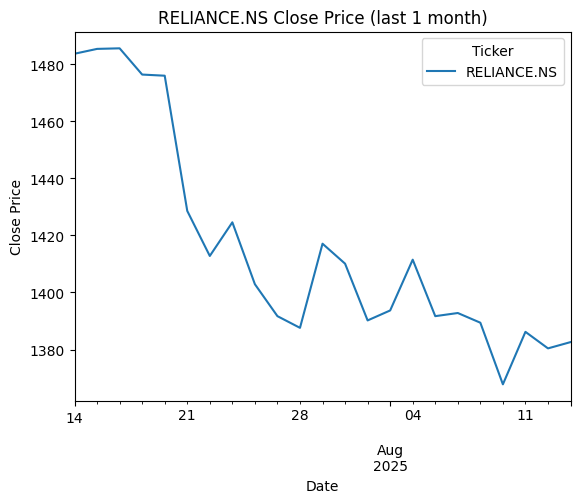

In [1]:
import sys, platform
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Check Python and library versions
print("Python:", sys.version.split()[0], "| OS:", platform.system(), platform.release())
print("numpy:", np.__version__, "| pandas:", pd.__version__)
print("matplotlib:", plt.matplotlib.__version__, "| yfinance:", yf.__version__)

# Download 1 month of stock data for Reliance (India) or Apple (US)
ticker = "RELIANCE.NS"  # change to "AAPL" if you want Apple
df = yf.download(ticker, period="1mo", interval="1d", progress=False)
print("Rows downloaded:", len(df))
display(df.tail(3))

# Quick chart to confirm plotting works
df["Close"].plot(title=f"{ticker} Close Price (last 1 month)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()


In [2]:
# --- Mini RAG Smoke Test (Embeddings + Local Vector Store) ---

from sentence_transformers import SentenceTransformer
import chromadb
from chromadb.config import Settings

# 1) Load a lightweight embedding model (downloads once)
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# 2) Start a local in-memory Chroma DB
client = chromadb.Client(Settings(anonymized_telemetry=False))
collection = client.create_collection(name="finance-mini")

# 3) Our tiny "knowledge base"
docs = [
    "Inflation risk is when rising prices reduce purchasing power and real returns.",
    "An earnings report summarizes a company’s revenue, profit, margins, and guidance.",
    "Market volatility describes how much and how quickly prices move over time.",
    "Diversification spreads investments across assets to reduce unsystematic risk.",
    "Free cash flow is operating cash flow minus capital expenditures."
]
ids = [f"doc-{i}" for i in range(len(docs))]

# 4) Embed and add to the vector store
embs = model.encode(docs, normalize_embeddings=True).tolist()
collection.add(documents=docs, ids=ids, embeddings=embs)

# 5) Ask a question
query = "What does inflation risk mean?"
q_emb = model.encode([query], normalize_embeddings=True).tolist()
res = collection.query(query_embeddings=q_emb, n_results=3)

print("Query:", query)
print("\nTop hits:")
for doc, score in zip(res["documents"][0], res["distances"][0]):
    print(f"- {doc}  (distance={score:.4f})")

print("\n If the top hit explains inflation risk, retrieval works.")


C:\Users\HP\anaconda3\envs\finrag\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\HP\anaconda3\envs\finrag\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\HP\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to act

Query: What does inflation risk mean?

Top hits:
- Inflation risk is when rising prices reduce purchasing power and real returns.  (distance=0.4510)
- Diversification spreads investments across assets to reduce unsystematic risk.  (distance=1.3822)
- Market volatility describes how much and how quickly prices move over time.  (distance=1.4144)

 If the top hit explains inflation risk, retrieval works.


In [4]:
# --- FIX: handle MultiIndex columns, then persist facts to Chroma and query ---

import os
from datetime import datetime
import pandas as pd
import chromadb
from sentence_transformers import SentenceTransformer

PROJECT_NAME = "fin_rag_project"
base_dir = os.path.join(os.getcwd(), PROJECT_NAME)
store_dir = os.path.join(base_dir, "vector_store")
os.makedirs(store_dir, exist_ok=True)
print(f"Project dir: {base_dir}\nVector store: {store_dir}")

ticker = "RELIANCE.NS"

# Ensure we have df with prices
try:
    df
except NameError:
    import yfinance as yf
    df = yf.download(ticker, period="1mo", interval="1d", progress=False)

# --- Normalize yfinance columns so 'Open/High/Low/Close/Volume' are usable ---
price_df = df.copy()
if isinstance(price_df.columns, pd.MultiIndex):
    lvl0 = list(price_df.columns.get_level_values(0))
    if all(x in lvl0 for x in ["Open", "High", "Low", "Close", "Volume"]):
        price_df.columns = price_df.columns.get_level_values(0)
    else:
        price_df.columns = [
            "_".join([str(x) for x in tup if x is not None and x != ""]).strip("_")
            for tup in price_df.columns
        ]

def colname(name: str) -> str:
    """Return the actual column name that starts with `name` (case-insensitive)."""
    if name in price_df.columns:
        return name
    for c in price_df.columns:
        if c.lower().startswith(name.lower()):
            return c
    raise KeyError(f"Column matching '{name}' not found in: {list(price_df.columns)}")

# --- Build short text facts from last few rows ---
recent = price_df.tail(min(7, len(price_df))).reset_index()
docs, metas, ids = [], [], []
for _, row in recent.iterrows():
    date_val = row["Date"]
    if not isinstance(date_val, (pd.Timestamp, datetime)):
        date_val = pd.to_datetime(date_val, errors="coerce")
    date_str = date_val.strftime("%Y-%m-%d") if pd.notnull(date_val) else str(row["Date"])

    close = float(row[colname("Close")])
    open_ = float(row[colname("Open")])
    high = float(row[colname("High")])
    low = float(row[colname("Low")])
    vol = int(float(row[colname("Volume")]))

    text = (f"On {date_str}, {ticker} closed at {close:.2f}, opened at {open_:.2f}, "
            f"high {high:.2f}, low {low:.2f}, with volume {vol}.")
    docs.append(text)
    metas.append({"ticker": ticker, "date": date_str})
    ids.append(f"{ticker}-{date_str}")

print(f"Prepared {len(docs)} text facts.")

# --- Embeddings model (reuse if already loaded) ---
try:
    model
except NameError:
    model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# --- Open a persistent Chroma DB ---
try:
    client = chromadb.PersistentClient(path=store_dir)
except Exception:
    from chromadb.config import Settings
    client = chromadb.Client(Settings(persist_directory=store_dir, anonymized_telemetry=False))

COLLECTION = "finance-docs"
try:
    collection = client.get_collection(COLLECTION)
except Exception:
    collection = client.create_collection(name=COLLECTION)

# --- Add new docs (skip existing IDs) ---
existing = set()
try:
    got = collection.get(ids=ids[:1])
    existing.update(got.get("ids", []))
except Exception:
    pass

to_add = [(d, m, i) for d, m, i in zip(docs, metas, ids) if i not in existing]
if to_add:
    add_docs, add_metas, add_ids = zip(*to_add)
    embs = model.encode(list(add_docs), normalize_embeddings=True).tolist()
    collection.add(documents=list(add_docs), metadatas=list(add_metas), ids=list(add_ids), embeddings=embs)
    print(f"Added {len(add_docs)} new facts.")
else:
    print("No new facts to add (already present).")

# --- Query the store to verify ---
question = "How did RELIANCE.NS close recently?"
q_emb = model.encode([question], normalize_embeddings=True).tolist()
res = collection.query(query_embeddings=q_emb, n_results=3)

print("\nQuery:", question)
print("Top hits:")
for doc, meta, dist in zip(res["documents"][0], res["metadatas"][0], res["distances"][0]):
    print(f"- {doc}  | {meta}  (distance={dist:.4f})")

print("\n Persistent RAG store is populated and queryable.")


Project dir: C:\Users\HP\fin_rag_project
Vector store: C:\Users\HP\fin_rag_project\vector_store
Prepared 7 text facts.
Added 7 new facts.

Query: How did RELIANCE.NS close recently?
Top hits:
- On 2025-08-05, RELIANCE.NS closed at 1391.70, opened at 1411.00, high 1411.00, low 1388.10, with volume 9315972.  | {'ticker': 'RELIANCE.NS', 'date': '2025-08-05'}  (distance=0.4170)
- On 2025-08-07, RELIANCE.NS closed at 1389.40, opened at 1387.70, high 1393.70, low 1366.00, with volume 9976705.  | {'ticker': 'RELIANCE.NS', 'date': '2025-08-07'}  (distance=0.4279)
- On 2025-08-06, RELIANCE.NS closed at 1392.80, opened at 1391.90, high 1395.90, low 1383.30, with volume 5834312.  | {'date': '2025-08-06', 'ticker': 'RELIANCE.NS'}  (distance=0.4345)

 Persistent RAG store is populated and queryable.


In [5]:
# --- Helper: ask() to query your persistent vector store ---

import os, pandas as pd, chromadb
from sentence_transformers import SentenceTransformer

PROJECT_NAME = "fin_rag_project"
store_dir = os.path.join(os.getcwd(), PROJECT_NAME, "vector_store")

# Connect to the same persistent store we created
try:
    client = chromadb.PersistentClient(path=store_dir)
except Exception:
    from chromadb.config import Settings
    client = chromadb.Client(Settings(persist_directory=store_dir, anonymized_telemetry=False))

COLLECTION = "finance-docs"
try:
    collection = client.get_collection(COLLECTION)
except Exception:
    collection = client.create_collection(name=COLLECTION)

# Reuse embedding model if already loaded; otherwise load it
try:
    model
except NameError:
    model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

def ask(question: str, top_k: int = 5):
    """Embed the question, retrieve top_k docs, and print nicely."""
    q_emb = model.encode([question], normalize_embeddings=True).tolist()
    res = collection.query(query_embeddings=q_emb, n_results=top_k)

    rows = []
    for doc, meta, dist in zip(res["documents"][0], res["metadatas"][0], res["distances"][0]):
        rows.append({
            "distance": float(dist),
            "date": meta.get("date"),
            "ticker": meta.get("ticker"),
            "doc": doc
        })
    hits = pd.DataFrame(rows).sort_values("distance")

    print(f"Q: {question}\n")
    for rank, r in enumerate(hits.itertuples(index=False), start=1):
        print(f"{rank}. {r.doc}  | {r.ticker} {r.date}  (distance={r.distance:.4f})")
    return hits

# Example query (you can change the text)
hits = ask("What were the latest closing levels for RELIANCE.NS?", top_k=3)


Q: What were the latest closing levels for RELIANCE.NS?

1. On 2025-08-05, RELIANCE.NS closed at 1391.70, opened at 1411.00, high 1411.00, low 1388.10, with volume 9315972.  | RELIANCE.NS 2025-08-05  (distance=0.3502)
2. On 2025-08-07, RELIANCE.NS closed at 1389.40, opened at 1387.70, high 1393.70, low 1366.00, with volume 9976705.  | RELIANCE.NS 2025-08-07  (distance=0.3514)
3. On 2025-08-06, RELIANCE.NS closed at 1392.80, opened at 1391.90, high 1395.90, low 1383.30, with volume 5834312.  | RELIANCE.NS 2025-08-06  (distance=0.3536)


In [6]:
# --- Ingest helpers: add any text or CSV content into the persistent vector store ---

import os, uuid
import pandas as pd
import chromadb
from sentence_transformers import SentenceTransformer
from datetime import datetime

PROJECT_NAME = "fin_rag_project"
store_dir = os.path.join(os.getcwd(), PROJECT_NAME, "vector_store")

# Connect to the same persistent store
try:
    client = chromadb.PersistentClient(path=store_dir)
except Exception:
    from chromadb.config import Settings
    client = chromadb.Client(Settings(persist_directory=store_dir, anonymized_telemetry=False))

COLLECTION = "finance-docs"
try:
    collection = client.get_collection(COLLECTION)
except Exception:
    collection = client.create_collection(name=COLLECTION)

# Reuse embedding model if available; otherwise load it
try:
    model
except NameError:
    model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

def _normalize_price_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Flatten MultiIndex columns from yfinance and return a frame with plain names."""
    out = df.copy()
    if isinstance(out.columns, pd.MultiIndex):
        lvl0 = list(out.columns.get_level_values(0))
        if all(x in lvl0 for x in ["Open", "High", "Low", "Close", "Volume"]):
            out.columns = out.columns.get_level_values(0)
        else:
            out.columns = [
                "_".join([str(x) for x in t if x is not None and x != ""]).strip("_")
                for t in out.columns
            ]
    return out

def ingest_texts(texts, base_meta=None):
    """Ingest a list of strings into the collection."""
    if base_meta is None:
        base_meta = {}
    ids = [str(uuid.uuid4()) for _ in texts]
    embs = model.encode(texts, normalize_embeddings=True).tolist()
    metadatas = [dict(base_meta) for _ in texts]
    collection.add(documents=list(texts), ids=ids, metadatas=metadatas, embeddings=embs)
    print(f"✅ Ingested {len(texts)} text items.")

def ingest_csv(csv_path, text_col="text", ticker_col="ticker"):
    """
    Ingest from a CSV.
    - If `text_col` exists: ingest that text directly.
    - Else, if it looks like OHLCV price data, build descriptive sentences per row.
    """
    df = pd.read_csv(csv_path)
    if text_col in df.columns:
        texts = df[text_col].dropna().astype(str).tolist()
        ingest_texts(texts, base_meta={"source": os.path.basename(csv_path)})
        return len(texts)

    # Try to build sentences from OHLCV-style data
    df = _normalize_price_columns(df)
    needed = {"Date", "Open", "High", "Low", "Close", "Volume"}
    if needed.issubset(set(df.columns)):
        texts = []
        metas = []
        for _, row in df.iterrows():
            # Parse date nicely
            d = pd.to_datetime(row["Date"], errors="coerce")
            date_str = d.strftime("%Y-%m-%d") if pd.notnull(d) else str(row["Date"])
            ticker = row[ticker_col] if ticker_col in df.columns else "UNKNOWN"
            try:
                o = float(row["Open"]); h = float(row["High"]); l = float(row["Low"])
                c = float(row["Close"]); v = int(float(row["Volume"]))
            except Exception:
                # skip rows with bad types
                continue
            texts.append(
                f"On {date_str}, {ticker} closed at {c:.2f}, opened at {o:.2f}, high {h:.2f}, low {l:.2f}, with volume {v}."
            )
            metas.append({"ticker": ticker, "date": date_str, "source": os.path.basename(csv_path)})
        if texts:
            ids = [str(uuid.uuid4()) for _ in texts]
            embs = model.encode(texts, normalize_embeddings=True).tolist()
            collection.add(documents=texts, ids=ids, metadatas=metas, embeddings=embs)
            print(f"✅ Ingested {len(texts)} OHLCV-derived facts from {os.path.basename(csv_path)}.")
            return len(texts)

    raise ValueError(
        f"CSV did not contain '{text_col}' or a full OHLCV set of columns. Columns found: {list(df.columns)}"
    )

# ---- Demo: ingest a couple of plain text notes, then query (you can replace these with your own) ----
sample_texts = [
    "The price-to-earnings (P/E) ratio equals price per share divided by earnings per share.",
    "Guidance is a management forecast of future performance such as revenue or EPS."
]
ingest_texts(sample_texts, base_meta={"source": "manual-notes"})

# Use your ask() helper if it exists; otherwise do a quick query inline
try:
    hits = ask("What is the P/E ratio?")
except NameError:
    q = "What is the P/E ratio?"
    q_emb = model.encode([q], normalize_embeddings=True).tolist()
    res = collection.query(query_embeddings=q_emb, n_results=3)
    print(f"\nQ: {q}\nTop hits:")
    for doc, meta, dist in zip(res["documents"][0], res["metadatas"][0], res["distances"][0]):
        print(f"- {doc}  | {meta}  (distance={dist:.4f})")


✅ Ingested 2 text items.
Q: What is the P/E ratio?

1. The price-to-earnings (P/E) ratio equals price per share divided by earnings per share.  | None None  (distance=0.4731)
2. On 2025-08-12, RELIANCE.NS closed at 1380.40, opened at 1381.90, high 1401.90, low 1375.20, with volume 12244664.  | RELIANCE.NS 2025-08-12  (distance=1.7689)
3. On 2025-08-13, RELIANCE.NS closed at 1382.60, opened at 1388.00, high 1391.80, low 1377.50, with volume 7454588.  | RELIANCE.NS 2025-08-13  (distance=1.7775)
4. On 2025-08-07, RELIANCE.NS closed at 1389.40, opened at 1387.70, high 1393.70, low 1366.00, with volume 9976705.  | RELIANCE.NS 2025-08-07  (distance=1.7847)
5. On 2025-08-08, RELIANCE.NS closed at 1367.80, opened at 1385.00, high 1397.20, low 1365.00, with volume 8793606.  | RELIANCE.NS 2025-08-08  (distance=1.7877)


In [9]:
# Save current price data to CSV, ingest it, and verify with a query

import os, pandas as pd

PROJECT_NAME = "fin_rag_project"
data_dir = os.path.join(os.getcwd(), PROJECT_NAME, "data")
os.makedirs(data_dir, exist_ok=True)

ticker = "RELIANCE.NS"

# Ensure we have price data; if not, fetch
try:
    df
except NameError:
    import yfinance as yf
    df = yf.download(ticker, period="1mo", interval="1d", progress=False)

# Normalize columns and add ticker
pdf = _normalize_price_columns(df).reset_index()
pdf["ticker"] = ticker

# Save to CSV inside the project
csv_path = os.path.join(data_dir, "reliance_prices.csv")
pdf.to_csv(csv_path, index=False)
print(f"Saved CSV: {csv_path}  | rows: {len(pdf)}")

# Ingest the CSV (uses your ingest_csv helper)
count = ingest_csv(csv_path, ticker_col="ticker")
print(f"Rows ingested from CSV: {count}")

# Verify using ask()
hits = ask("Show recent closing info from the CSV for RELIANCE.NS.", top_k=3)


Saved CSV: C:\Users\HP\fin_rag_project\data\reliance_prices.csv  | rows: 23
✅ Ingested 23 OHLCV-derived facts from reliance_prices.csv.
Rows ingested from CSV: 23
Q: Show recent closing info from the CSV for RELIANCE.NS.

1. On 2025-07-23, RELIANCE.NS closed at 1424.60, opened at 1426.00, high 1426.00, low 1414.40, with volume 8354596.  | RELIANCE.NS 2025-07-23  (distance=0.5199)
2. On 2025-07-23, RELIANCE.NS closed at 1424.60, opened at 1426.00, high 1426.00, low 1414.40, with volume 8354596.  | RELIANCE.NS 2025-07-23  (distance=0.5199)
3. On 2025-07-21, RELIANCE.NS closed at 1428.60, opened at 1465.00, high 1476.00, low 1423.10, with volume 22442744.  | RELIANCE.NS 2025-07-21  (distance=0.5354)


In [10]:
# --- Generate daily summaries from prices, ingest, and verify ---

import os, numpy as np, pandas as pd, chromadb
from datetime import datetime
from sentence_transformers import SentenceTransformer

PROJECT_NAME = "fin_rag_project"
base_dir = os.path.join(os.getcwd(), PROJECT_NAME)
data_dir = os.path.join(base_dir, "data")
store_dir = os.path.join(base_dir, "vector_store")
ticker = "RELIANCE.NS"

# 1) Load price data (CSV you saved) or fallback to df in memory
csv_path = os.path.join(data_dir, "reliance_prices.csv")
if os.path.exists(csv_path):
    pdf = pd.read_csv(csv_path, parse_dates=["Date"])
else:
    try:
        pdf = _normalize_price_columns(df).reset_index()
        pdf["Date"] = pd.to_datetime(pdf["Date"], errors="coerce")
        pdf["ticker"] = ticker
    except NameError:
        import yfinance as yf
        raw = yf.download(ticker, period="1mo", interval="1d", progress=False)
        pdf = raw.reset_index()
        pdf["ticker"] = ticker

pdf = pdf.sort_values("Date").reset_index(drop=True)

# 2) Compute features for summaries
pdf["PrevClose"] = pdf["Close"].shift(1)
pdf["Change"] = pdf["Close"] - pdf["PrevClose"]
pdf["Pct"] = (pdf["Change"] / pdf["PrevClose"] * 100).replace([np.inf, -np.inf], np.nan)
pdf["SMA5"] = pdf["Close"].rolling(5, min_periods=1).mean()
pdf["SMA10"] = pdf["Close"].rolling(10, min_periods=1).mean()
pdf["VolAvg20"] = pdf["Volume"].rolling(20, min_periods=1).mean()
pdf["VolTag"] = np.where(pdf["Volume"] >= pdf["VolAvg20"], "above 20D avg", "below 20D avg")

# 3) Build summary sentences (skip the first row without PrevClose)
summ_docs, summ_ids, summ_meta = [], [], []
for _, r in pdf.dropna(subset=["PrevClose"]).iterrows():
    d = r["Date"].strftime("%Y-%m-%d")
    chg = float(r["Change"])
    pct = float(r["Pct"])
    sign = "+" if chg >= 0 else "-"
    text = (
        f"Summary for {d}: {ticker} closed at {r['Close']:.2f} "
        f"({sign}{abs(chg):.2f}, {sign}{abs(pct):.2f}%). "
        f"Day range {r['Low']:.2f}-{r['High']:.2f}. "
        f"SMA5 {r['SMA5']:.2f}, SMA10 {r['SMA10']:.2f}. "
        f"Volume {int(r['Volume'])} ({r['VolTag']})."
    )
    summ_docs.append(text)
    summ_ids.append(f"{ticker}-summary-{d}")
    summ_meta.append({"ticker": ticker, "date": d, "kind": "daily_summary"})

print(f"Prepared {len(summ_docs)} daily summaries.")

# 4) Connect to persistent Chroma and ingest (skip if already added)
try:
    client = chromadb.PersistentClient(path=store_dir)
except Exception:
    from chromadb.config import Settings
    client = chromadb.Client(Settings(persist_directory=store_dir, anonymized_telemetry=False))

COLLECTION = "finance-docs"
try:
    collection = client.get_collection(COLLECTION)
except Exception:
    collection = client.create_collection(name=COLLECTION)

# Load / reuse embedding model
try:
    model
except NameError:
    model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Determine which IDs are new
existing = set()
try:
    got = collection.get(ids=summ_ids[:1])
    existing.update(got.get("ids", []))
except Exception:
    pass

to_add = [(d, m, i) for d, m, i in zip(summ_docs, summ_meta, summ_ids) if i not in existing]
if to_add:
    add_docs, add_meta, add_ids = zip(*to_add)
    embs = model.encode(list(add_docs), normalize_embeddings=True).tolist()
    collection.add(documents=list(add_docs), metadatas=list(add_meta), ids=list(add_ids), embeddings=embs)
    print(f"✅ Added {len(add_docs)} daily summaries.")
else:
    print("No new daily summaries to add (already present).")

# 5) Verify: ask for the latest summary (filter to this ticker)
q = "What's the latest daily summary for RELIANCE.NS?"
q_emb = model.encode([q], normalize_embeddings=True).tolist()
res = collection.query(query_embeddings=q_emb, n_results=3, where={"ticker": ticker})

print(f"\nQ: {q}\nTop hits:")
for doc, meta, dist in zip(res["documents"][0], res["metadatas"][0], res["distances"][0]):
    print(f"- {doc}  | {meta}  (distance={dist:.4f})")


Prepared 22 daily summaries.
✅ Added 22 daily summaries.

Q: What's the latest daily summary for RELIANCE.NS?
Top hits:
- Summary for 2025-07-22: RELIANCE.NS closed at 1412.80 (-15.80, -1.11%). Day range 1410.70-1431.90. SMA5 1455.88, SMA10 1464.07. Volume 20396320 (above 20D avg).  | {'date': '2025-07-22', 'ticker': 'RELIANCE.NS', 'kind': 'daily_summary'}  (distance=0.4522)
- Summary for 2025-07-23: RELIANCE.NS closed at 1424.60 (+11.80, +0.84%). Day range 1414.40-1426.00. SMA5 1443.68, SMA10 1459.14. Volume 8354596 (below 20D avg).  | {'ticker': 'RELIANCE.NS', 'kind': 'daily_summary', 'date': '2025-07-23'}  (distance=0.4544)
- Summary for 2025-07-30: RELIANCE.NS closed at 1410.10 (-7.00, -0.49%). Day range 1401.30-1423.30. SMA5 1401.88, SMA10 1422.78. Volume 7209849 (below 20D avg).  | {'ticker': 'RELIANCE.NS', 'kind': 'daily_summary', 'date': '2025-07-30'}  (distance=0.4566)


In [11]:
# Create a minimal Streamlit app to query your persistent vector store

import os, sys, subprocess

# 1) Ensure streamlit is available in this environment
subprocess.run([sys.executable, "-m", "pip", "install", "streamlit"], check=False)

# 2) Write the app file into your project folder
PROJECT_NAME = "fin_rag_project"
base_dir = os.path.join(os.getcwd(), PROJECT_NAME)
os.makedirs(base_dir, exist_ok=True)
app_path = os.path.join(base_dir, "app.py")

app_code = r'''
import os
import streamlit as st
import chromadb
from sentence_transformers import SentenceTransformer

# Resolve paths relative to this file (robust when launched from anywhere)
BASE = os.path.dirname(os.path.abspath(__file__))
store_dir = os.path.join(BASE, "vector_store")
COLLECTION = "finance-docs"

# Connect to the persistent Chroma store
try:
    client = chromadb.PersistentClient(path=store_dir)
except Exception:
    from chromadb.config import Settings
    client = chromadb.Client(Settings(persist_directory=store_dir, anonymized_telemetry=False))

collection = client.get_collection(COLLECTION)

@st.cache_resource
def load_model():
    return SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

model = load_model()

st.title("Finance RAG — Quick Search")
st.write("Query the facts and daily summaries you ingested.")

query = st.text_input("Your question:", "What's the latest daily summary for RELIANCE.NS?")
ticker = st.text_input("Ticker filter (optional):", "RELIANCE.NS")
top_k = st.slider("Number of results", 1, 10, 5)

if st.button("Search"):
    q_emb = model.encode([query], normalize_embeddings=True).tolist()
    where = {"ticker": ticker} if ticker else None
    res = collection.query(query_embeddings=q_emb, n_results=top_k, where=where)
    hits = list(zip(res["documents"][0], res["metadatas"][0], res["distances"][0]))

    if not hits:
        st.warning("No results. Try removing the ticker filter or adding more data.")
    else:
        for i, (doc, meta, dist) in enumerate(hits, start=1):
            st.markdown(f"**{i}.** {doc}")
            st.caption(f"meta={meta} · distance={dist:.4f}")
'''

with open(app_path, "w", encoding="utf-8") as f:
    f.write(app_code)

print("✅ Wrote Streamlit app:", app_path)
print("\nTo launch the UI, open Anaconda Prompt (with the 'finrag' env active) and run:")
print(f"streamlit run \"{app_path}\"")


✅ Wrote Streamlit app: C:\Users\HP\fin_rag_project\app.py

To launch the UI, open Anaconda Prompt (with the 'finrag' env active) and run:
streamlit run "C:\Users\HP\fin_rag_project\app.py"


In [ ]:
# Ingest INFY.NS and TCS.NS: OHLCV facts + daily summaries

import os, numpy as np, pandas as pd, chromadb
from datetime import datetime
from sentence_transformers import SentenceTransformer
import yfinance as yf

PROJECT_NAME = "fin_rag_project"
base_dir  = os.path.join(os.getcwd(), PROJECT_NAME)
data_dir  = os.path.join(base_dir, "data")
store_dir = os.path.join(base_dir, "vector_store")
os.makedirs(data_dir, exist_ok=True)

# Connect to persistent Chroma
try:
    client = chromadb.PersistentClient(path=store_dir)
except Exception:
    from chromadb.config import Settings
    client = chromadb.Client(Settings(persist_directory=store_dir, anonymized_telemetry=False))

COLLECTION = "finance-docs"
try:
    collection = client.get_collection(COLLECTION)
except Exception:
    collection = client.create_collection(name=COLLECTION)

# Reuse model if already loaded; otherwise load it
try:
    model
except NameError:
    model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

def _normalize_price_columns(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    if isinstance(out.columns, pd.MultiIndex):
        lvl0 = list(out.columns.get_level_values(0))
        if all(x in lvl0 for x in ["Open", "High", "Low", "Close", "Volume"]):
            out.columns = out.columns.get_level_values(0)
        else:
            out.columns = ["_".join([str(x) for x in t if x]).strip("_") for t in out.columns]
    return out

def build_daily_summaries(pdf: pd.DataFrame, ticker: str):
    pdf = pdf.sort_values("Date").reset_index(drop=True)
    pdf["PrevClose"] = pdf["Close"].shift(1)
    pdf["Change"]    = pdf["Close"] - pdf["PrevClose"]
    pdf["Pct"]       = (pdf["Change"] / pdf["PrevClose"] * 100).replace([np.inf, -np.inf], np.nan)
    pdf["SMA5"]      = pdf["Close"].rolling(5,  min_periods=1).mean()
    pdf["SMA10"]     = pdf["Close"].rolling(10, min_periods=1).mean()
    pdf["VolAvg20"]  = pdf["Volume"].rolling(20, min_periods=1).mean()
    pdf["VolTag"]    = np.where(pdf["Volume"] >= pdf["VolAvg20"], "above 20D avg", "below 20D avg")

    docs, ids, meta = [], [], []
    for _, r in pdf.dropna(subset=["PrevClose"]).iterrows():
        d = pd.to_datetime(r["Date"]).strftime("%Y-%m-%d")
        chg, pct = float(r["Change"]), float(r["Pct"])
        sign = "+" if chg >= 0 else "-"
        docs.append(
            f"Summary for {d}: {ticker} closed at {r['Close']:.2f} "
            f"({sign}{abs(chg):.2f}, {sign}{abs(pct):.2f}%). "
            f"Day range {r['Low']:.2f}-{r['High']:.2f}. "
            f"SMA5 {r['SMA5']:.2f}, SMA10 {r['SMA10']:.2f}. "
            f"Volume {int(r['Volume'])} ({r['VolTag']})."
        )
        ids.append(f"{ticker}-summary-{d}")
        meta.append({"ticker": ticker, "date": d, "kind": "daily_summary"})
    return docs, ids, meta

tickers = ["INFY.NS", "TCS.NS"]
tot_facts = tot_summ = 0

for tkr in tickers:
    raw = yf.download(tkr, period="1mo", interval="1d", progress=False)
    if raw is None or len(raw) == 0:
        print(f"Skipping {tkr}: no data.")
        continue

    pdf = _normalize_price_columns(raw).reset_index()
    pdf["ticker"] = tkr

    # Save CSV
    csv_path = os.path.join(data_dir, f"{tkr.replace('.', '_')}_prices.csv")
    pdf.to_csv(csv_path, index=False)

    # Build OHLCV fact sentences
    docs, metas, ids = [], [], []
    for _, r in pdf.iterrows():
        d = pd.to_datetime(r["Date"], errors="coerce")
        dstr = d.strftime("%Y-%m-%d") if pd.notnull(d) else str(r["Date"])
        try:
            o,h,l,c,v = float(r["Open"]), float(r["High"]), float(r["Low"]), float(r["Close"]), int(float(r["Volume"]))
        except Exception:
            continue
        docs.append(f"On {dstr}, {tkr} closed at {c:.2f}, opened at {o:.2f}, high {h:.2f}, low {l:.2f}, with volume {v}.")
        metas.append({"ticker": tkr, "date": dstr, "source": os.path.basename(csv_path)})
        ids.append(f"{tkr}-{dstr}")

    if docs:
        embs = model.encode(docs, normalize_embeddings=True).tolist()
        collection.add(documents=docs, metadatas=metas, ids=ids, embeddings=embs)
        tot_facts += len(docs)

    # Build + add daily summaries
    s_docs, s_ids, s_meta = build_daily_summaries(pdf.rename(columns=str), tkr)
    if s_docs:
        s_embs = model.encode(s_docs, normalize_embeddings=True).tolist()
        collection.add(documents=s_docs, metadatas=s_meta, ids=s_ids, embeddings=s_embs)
        tot_summ += len(s_docs)

    print(f"✅ {tkr}: added {len(docs)} facts, {len(s_docs)} summaries. CSV: {csv_path}")

print(f"\nDone. Added totals → facts: {tot_facts}, summaries: {tot_summ}")


In [1]:
# Ingest INFY.NS and TCS.NS into the persistent vector store (facts + daily summaries)

import os, numpy as np, pandas as pd, chromadb
from sentence_transformers import SentenceTransformer
import yfinance as yf

PROJECT_NAME = "fin_rag_project"
base_dir  = os.path.join(os.getcwd(), PROJECT_NAME)
data_dir  = os.path.join(base_dir, "data")
store_dir = os.path.join(base_dir, "vector_store")
os.makedirs(data_dir, exist_ok=True)

# Connect to persistent Chroma
try:
    client = chromadb.PersistentClient(path=store_dir)
except Exception:
    from chromadb.config import Settings
    client = chromadb.Client(Settings(persist_directory=store_dir, anonymized_telemetry=False))

COLLECTION = "finance-docs"
try:
    collection = client.get_collection(COLLECTION)
except Exception:
    collection = client.create_collection(name=COLLECTION)

# Model (reuse if already loaded)
try:
    model
except NameError:
    model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

def _normalize_price_columns(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    if isinstance(out.columns, pd.MultiIndex):
        lvl0 = list(out.columns.get_level_values(0))
        if all(x in lvl0 for x in ["Open","High","Low","Close","Volume"]):
            out.columns = out.columns.get_level_values(0)
        else:
            out.columns = ["_".join([str(x) for x in t if x]).strip("_") for t in out.columns]
    return out

def build_daily_summaries(pdf: pd.DataFrame, ticker: str):
    pdf = pdf.sort_values("Date").reset_index(drop=True)
    pdf["PrevClose"] = pdf["Close"].shift(1)
    pdf["Change"]    = pdf["Close"] - pdf["PrevClose"]
    pdf["Pct"]       = (pdf["Change"] / pdf["PrevClose"] * 100).replace([np.inf, -np.inf], np.nan)
    pdf["SMA5"]      = pdf["Close"].rolling(5,  min_periods=1).mean()
    pdf["SMA10"]     = pdf["Close"].rolling(10, min_periods=1).mean()
    pdf["VolAvg20"]  = pdf["Volume"].rolling(20, min_periods=1).mean()
    pdf["VolTag"]    = np.where(pdf["Volume"] >= pdf["VolAvg20"], "above 20D avg", "below 20D avg")

    docs, ids, meta = [], [], []
    for _, r in pdf.dropna(subset=["PrevClose"]).iterrows():
        d = pd.to_datetime(r["Date"]).strftime("%Y-%m-%d")
        chg, pct = float(r["Change"]), float(r["Pct"])
        sign = "+" if chg >= 0 else "-"
        docs.append(
            f"Summary for {d}: {ticker} closed at {r['Close']:.2f} "
            f"({sign}{abs(chg):.2f}, {sign}{abs(pct):.2f}%). "
            f"Day range {r['Low']:.2f}-{r['High']:.2f}. "
            f"SMA5 {r['SMA5']:.2f}, SMA10 {r['SMA10']:.2f}. "
            f"Volume {int(r['Volume'])} ({r['VolTag']})."
        )
        ids.append(f"{ticker}-summary-{d}")
        meta.append({"ticker": ticker, "date": d, "kind": "daily_summary"})
    return docs, ids, meta

tickers = ["INFY.NS", "TCS.NS"]
tot_facts = tot_summ = 0

for tkr in tickers:
    raw = yf.download(tkr, period="1mo", interval="1d", progress=False)
    if raw is None or len(raw) == 0:
        print(f"Skipping {tkr}: no data.")
        continue

    pdf = _normalize_price_columns(raw).reset_index()
    pdf["ticker"] = tkr

    # Save CSV
    csv_path = os.path.join(data_dir, f"{tkr.replace('.', '_')}_prices.csv")
    pdf.to_csv(csv_path, index=False)

    # OHLCV fact sentences
    docs, metas, ids = [], [], []
    for _, r in pdf.iterrows():
        d = pd.to_datetime(r["Date"], errors="coerce")
        dstr = d.strftime("%Y-%m-%d") if pd.notnull(d) else str(r["Date"])
        try:
            o,h,l,c,v = float(r["Open"]), float(r["High"]), float(r["Low"]), float(r["Close"]), int(float(r["Volume"]))
        except Exception:
            continue
        docs.append(f"On {dstr}, {tkr} closed at {c:.2f}, opened at {o:.2f}, high {h:.2f}, low {l:.2f}, with volume {v}.")
        metas.append({"ticker": tkr, "date": dstr, "source": os.path.basename(csv_path)})
        ids.append(f"{tkr}-{dstr}")

    if docs:
        embs = model.encode(docs, normalize_embeddings=True).tolist()
        collection.add(documents=docs, metadatas=metas, ids=ids, embeddings=embs)
        tot_facts += len(docs)

    # Daily summaries
    s_docs, s_ids, s_meta = build_daily_summaries(pdf.rename(columns=str), tkr)
    if s_docs:
        s_embs = model.encode(s_docs, normalize_embeddings=True).tolist()
        collection.add(documents=s_docs, metadatas=s_meta, ids=s_ids, embeddings=s_embs)
        tot_summ += len(s_docs)

    print(f"✅ {tkr}: added {len(docs)} facts, {len(s_docs)} summaries. CSV: {csv_path}")

print(f"\nDone. Added totals → facts: {tot_facts}, summaries: {tot_summ}")


C:\Users\HP\anaconda3\envs\finrag\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\HP\AppData\Local\Temp\ipykernel_15588\1298771793.py:72: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw = yf.download(tkr, period="1mo", interval="1d", progress=False)


✅ INFY.NS: added 23 facts, 22 summaries. CSV: C:\Users\HP\fin_rag_project\fin_rag_project\data\INFY_NS_prices.csv


C:\Users\HP\AppData\Local\Temp\ipykernel_15588\1298771793.py:72: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw = yf.download(tkr, period="1mo", interval="1d", progress=False)


✅ TCS.NS: added 23 facts, 22 summaries. CSV: C:\Users\HP\fin_rag_project\fin_rag_project\data\TCS_NS_prices.csv

Done. Added totals → facts: 46, summaries: 44


In [1]:
# List unique tickers that are already in the Chroma collection
import os, chromadb

# Use the project folder path explicitly (safest)
store_dir = r"C:\Users\HP\fin_rag_project\vector_store"

client = chromadb.PersistentClient(path=store_dir)
col = client.get_collection("finance-docs")

rows = col.get(include=["metadatas"], limit=10000)
tickers = sorted({m.get("ticker") for m in rows["metadatas"] if m and m.get("ticker")})
print("Vector store:", store_dir)
print("Tickers in store:", tickers)


Vector store: C:\Users\HP\fin_rag_project\vector_store
Tickers in store: ['GOOGL', 'INFY.NS', 'RELIANCE.NS', 'TCS.NS', 'TECHM.NS', 'TSLA']


In [7]:
# --- one time at the top of the notebook ---
import os, pandas as pd, numpy as np, chromadb, yfinance as yf
from sentence_transformers import SentenceTransformer

BASE = os.path.dirname(os.path.abspath("app.py"))
STORE_DIR = os.path.join(BASE, "vector_store")
COLLECTION = "finance-docs"

client = chromadb.PersistentClient(path=STORE_DIR)
try:
    col = client.get_collection(COLLECTION)
except Exception:
    col = client.create_collection(COLLECTION)

try:
    model
except NameError:
    model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")


In [8]:
def ingest_more(tickers):
    total = 0
    for tkr in tickers:
        df = yf.download(
            tkr, period="1mo", interval="1d",
            progress=False, auto_adjust=True
        )
        if df is None or df.empty:
            print(f"Skipping {tkr}: no data.")
            continue

        # Normalize columns and ensure a single datetime 'Date' column
        df = df.reset_index()                                # bring 'Date' out of index
        df = df.loc[:, ~df.columns.duplicated(keep='first')] # drop duplicate col names
        if isinstance(df.columns, pd.MultiIndex):            # flatten multi-index cols
            df.columns = df.columns.get_level_values(0)
        df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

        docs, metas, ids = [], [], []
        for _, r in df.iterrows():
            d = r["Date"].strftime("%Y-%m-%d")
            o = float(r["Open"]);   h = float(r["High"])
            l = float(r["Low"]);    c = float(r["Close"])
            v = int(float(r["Volume"]))
            docs.append(
                f"On {d}, {tkr} closed at {c:.2f}, opened at {o:.2f}, "
                f"high {h:.2f}, low {l:.2f}, with volume {v}."
            )
            metas.append({"ticker": tkr, "date": d})
            ids.append(f"{tkr}-{d}")

        embs = model.encode(docs, normalize_embeddings=True).tolist()
        col.add(documents=docs, metadatas=metas, ids=ids, embeddings=embs)
        print(f"✅ Ingested {tkr}: {len(docs)} facts")
        total += len(docs)

    print(f"Done. Added {total} facts.")


In [9]:
ingest_more(["TSLA", "GOOGL", "MSFT", "TECHM.NS"])


✅ Ingested TSLA: 24 facts
✅ Ingested GOOGL: 24 facts



1 Failed download:
['MSFT']: Timeout('Failed to perform, curl: (28) Operation timed out after 10010 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


Skipping MSFT: no data.



1 Failed download:
['TECHM.NS']: Timeout('Failed to perform, curl: (28) Connection timed out after 10014 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


Skipping TECHM.NS: no data.
Done. Added 48 facts.


In [10]:
ingest_more(["MSFT"])
ingest_more(["TECHM.NS"])


✅ Ingested MSFT: 24 facts
Done. Added 24 facts.
✅ Ingested TECHM.NS: 24 facts
Done. Added 24 facts.


In [13]:
# Cell 1 — imports and connect to the same Chroma store used by your Streamlit app

import os
import pandas as pd
import chromadb
import yfinance as yf
from sentence_transformers import SentenceTransformer

# Paths must match your Streamlit app
BASE       = os.path.dirname(os.path.abspath("app.py"))   # folder that contains app.py
STORE_DIR  = os.path.join(BASE, "vector_store")
COLLECTION = "finance-docs"

# Connect to persistent Chroma
client = chromadb.PersistentClient(path=STORE_DIR)
try:
    col = client.get_collection(COLLECTION)
    created = False
except Exception:
    col = client.create_collection(COLLECTION)
    created = True

# Load embedding model once (cached across cells)
try:
    model
except NameError:
    model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Simple confirmation prints
print(f"BASE       : {BASE}")
print(f"STORE_DIR  : {STORE_DIR}")
print(f"Collection : {COLLECTION} ({'created' if created else 'opened'})")

# Try a tiny read to confirm the collection is responsive
try:
    _probe = col.get(ids=[], limit=1)
    print("Chroma connection OK.")
except Exception as e:
    print("Chroma probe failed:", repr(e))


BASE       : C:\Users\HP\fin_rag_project
STORE_DIR  : C:\Users\HP\fin_rag_project\vector_store
Collection : finance-docs (opened)
Chroma probe failed: ValueError('Expected IDs to be a non-empty list, got 0 IDs in get.')


In [14]:
# Cell 2 — sanity check: count docs and list unique tickers already in the store

# How many documents are in the collection?
try:
    total_docs = col.count()
except Exception as e:
    total_docs = None
    print("count() not available:", repr(e))

print("Total docs in collection:", total_docs)

# Pull metadatas and list unique tickers
rows = col.get(include=["metadatas"], limit=10000)  # increase limit if you know you have more
metas = rows.get("metadatas", []) or []
tickers_in_store = sorted({ m.get("ticker") for m in metas if m and m.get("ticker") })

print("Tickers currently in store:", tickers_in_store)
print("Unique tickers count:", len(tickers_in_store))


Total docs in collection: 304
Tickers currently in store: ['GOOGL', 'INFY.NS', 'MSFT', 'RELIANCE.NS', 'TCS.NS', 'TECHM.NS', 'TSLA']
Unique tickers count: 7


In [15]:
# Cell 3 — define a robust ingestion helper to add NEW tickers (or new days) safely

import pandas as pd
import numpy as np
import yfinance as yf
from sentence_transformers import SentenceTransformer

# Reuse a model if one is already loaded in this notebook; otherwise load it
try:
    model
except NameError:
    model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

def _filter_missing_ids(col, ids, chunk=200):
    """
    Return only those IDs that are NOT already present in the Chroma collection.
    Chunks requests to keep the call sizes small.
    """
    missing = []
    for i in range(0, len(ids), chunk):
        part = ids[i:i+chunk]
        try:
            got = col.get(ids=part)
            present = set((got or {}).get("ids", []) or [])
        except Exception:
            present = set()
        for j, _id in enumerate(part):
            if _id not in present:
                missing.append(_id)
    return set(missing)

def ingest_more(tickers):
    """
    Download ~1 month of daily OHLCV for each ticker and add fact sentences
    to the existing 'finance-docs' collection, skipping duplicates.
    """
    grand_total = 0
    for tkr in tickers:
        print(f"\n▶ Ingesting {tkr} …")
        df = yf.download(tkr, period="1mo", interval="1d",
                         progress=False, auto_adjust=True)
        if df is None or df.empty:
            print(f"  Skipping {tkr}: no data.")
            continue

        # Normalize columns (handles MultiIndex, duplicates, and date type)
        df = df.reset_index()
        df = df.loc[:, ~df.columns.duplicated(keep="first")]
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(0)

        # Try to ensure we have a 'Date' column with Timestamp values
        if "Date" not in df.columns:
            for cand in ["Datetime", "datetime", "date"]:
                if cand in df.columns:
                    df = df.rename(columns={cand: "Date"})
                    break
        df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

        keep = ["Date", "Open", "High", "Low", "Close", "Volume"]
        df = df.dropna(subset=[c for c in keep if c in df.columns])
        if any(c not in df.columns for c in keep):
            print(f"  Skipping {tkr}: required columns missing after normalization.")
            continue

        docs, metas, ids = [], [], []
        for _, r in df.iterrows():
            d = r["Date"]
            if pd.isna(d):
                continue
            d_str = pd.Timestamp(d).strftime("%Y-%m-%d")
            try:
                o = float(r["Open"]);  h = float(r["High"])
                l = float(r["Low"]);   c = float(r["Close"])
                v = int(float(r["Volume"]))
            except Exception:
                # skip malformed rows
                continue

            docs.append(
                f"On {d_str}, {tkr} closed at {c:.2f}, opened at {o:.2f}, "
                f"high {h:.2f}, low {l:.2f}, with volume {v}."
            )
            metas.append({"ticker": tkr, "date": d_str})
            ids.append(f"{tkr}-{d_str}")

        if not docs:
            print(f"  Nothing to add for {tkr}.")
            continue

        # Skip any IDs already present in the collection
        missing = _filter_missing_ids(col, ids)
        if not missing:
            print(f"  All {tkr} items already present — nothing new to add.")
            continue

        keep_mask = [(_id in missing) for _id in ids]
        docs_keep  = [d for d, k in zip(docs,  keep_mask) if k]
        metas_keep = [m for m, k in zip(metas, keep_mask) if k]
        ids_keep   = [i for i, k in zip(ids,   keep_mask) if k]

        embs = model.encode(docs_keep, normalize_embeddings=True).tolist()
        col.add(documents=docs_keep, metadatas=metas_keep, ids=ids_keep, embeddings=embs)

        print(f"  ✅ Ingested {tkr}: {len(docs_keep)} new facts (skipped {len(docs)-len(docs_keep)} duplicates).")
        grand_total += len(docs_keep)

    print(f"\nDone. Added {grand_total} new facts in total.")


In [16]:
# Cell 3 (lean) — no re-imports; assumes pd, yf, SentenceTransformer, and `col` already exist.

# Reuse model if it’s already in memory, else load it once
try:
    model
except NameError:
    model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

def _filter_missing_ids(col, ids, chunk=200):
    """Return the subset of IDs not already present in Chroma (chunked to keep calls small)."""
    missing = []
    for i in range(0, len(ids), chunk):
        part = ids[i:i+chunk]
        try:
            got = col.get(ids=part)
            present = set((got or {}).get("ids", []) or [])
        except Exception:
            present = set()
        for _id in part:
            if _id not in present:
                missing.append(_id)
    return set(missing)

def ingest_more(tickers):
    """Add ~1 month of daily OHLCV fact sentences for each ticker, skipping duplicates."""
    grand_total = 0
    for tkr in tickers:
        print(f"\n▶ Ingesting {tkr} …")
        df = yf.download(tkr, period="1mo", interval="1d", progress=False, auto_adjust=True)
        if df is None or df.empty:
            print(f"  Skipping {tkr}: no data.")
            continue

        # Normalize columns
        df = df.reset_index()
        df = df.loc[:, ~df.columns.duplicated(keep="first")]
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(0)
        if "Date" not in df.columns:
            for cand in ["Datetime", "datetime", "date"]:
                if cand in df.columns:
                    df = df.rename(columns={cand: "Date"})
                    break
        df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

        keep = ["Date", "Open", "High", "Low", "Close", "Volume"]
        df = df.dropna(subset=[c for c in keep if c in df.columns])
        if any(c not in df.columns for c in keep):
            print(f"  Skipping {tkr}: required columns missing after normalization.")
            continue

        docs, metas, ids = [], [], []
        for _, r in df.iterrows():
            d = r["Date"]
            if pd.isna(d):
                continue
            d_str = pd.Timestamp(d).strftime("%Y-%m-%d")
            try:
                o = float(r["Open"]);  h = float(r["High"])
                l = float(r["Low"]);   c = float(r["Close"])
                v = int(float(r["Volume"]))
            except Exception:
                continue

            docs.append(
                f"On {d_str}, {tkr} closed at {c:.2f}, opened at {o:.2f}, "
                f"high {h:.2f}, low {l:.2f}, with volume {v}."
            )
            metas.append({"ticker": tkr, "date": d_str})
            ids.append(f"{tkr}-{d_str}")

        if not docs:
            print(f"  Nothing to add for {tkr}.")
            continue

        missing = _filter_missing_ids(col, ids)
        if not missing:
            print(f"  All {tkr} items already present — nothing new to add.")
            continue

        keep_mask = [(_id in missing) for _id in ids]
        docs_keep  = [d for d, k in zip(docs,  keep_mask) if k]
        metas_keep = [m for m, k in zip(metas, keep_mask) if k]
        ids_keep   = [i for i, k in zip(ids,   keep_mask) if k]

        embs = model.encode(docs_keep, normalize_embeddings=True).tolist()
        col.add(documents=docs_keep, metadatas=metas_keep, ids=ids_keep, embeddings=embs)

        print(f"  ✅ Ingested {tkr}: {len(docs_keep)} new facts (skipped {len(docs)-len(docs_keep)} duplicates).")
        grand_total += len(docs_keep)

    print(f"\nDone. Added {grand_total} new facts in total.")


In [17]:
# Cell 4 — add tickers (change the list as you like)
ingest_more(["TSLA", "GOOGL", "MSFT", "TECHM.NS"])



▶ Ingesting TSLA …
  All TSLA items already present — nothing new to add.

▶ Ingesting GOOGL …
  All GOOGL items already present — nothing new to add.

▶ Ingesting MSFT …
  All MSFT items already present — nothing new to add.

▶ Ingesting TECHM.NS …
  All TECHM.NS items already present — nothing new to add.

Done. Added 0 new facts in total.


In [18]:
# US examples
ingest_more(["AAPL", "NVDA", "AMZN", "META"])

# or India (NSE) examples
# ingest_more(["HDFCBANK.NS", "ICICIBANK.NS", "TATASTEEL.NS", "LT.NS"])



▶ Ingesting AAPL …
  ✅ Ingested AAPL: 24 new facts (skipped 0 duplicates).

▶ Ingesting NVDA …
  ✅ Ingested NVDA: 24 new facts (skipped 0 duplicates).

▶ Ingesting AMZN …
  ✅ Ingested AMZN: 24 new facts (skipped 0 duplicates).

▶ Ingesting META …
  ✅ Ingested META: 24 new facts (skipped 0 duplicates).

Done. Added 96 new facts in total.


In [19]:
def ingest_more_period(tickers, period="6mo"):
    grand_total = 0
    for tkr in tickers:
        print(f"\n▶ Ingesting {tkr} for period={period} …")
        df = yf.download(tkr, period=period, interval="1d",
                         progress=False, auto_adjust=True)
        if df is None or df.empty:
            print(f"  Skipping {tkr}: no data.")
            continue

        df = df.reset_index()
        df = df.loc[:, ~df.columns.duplicated(keep="first")]
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(0)
        if "Date" not in df.columns:
            for cand in ["Datetime", "datetime", "date"]:
                if cand in df.columns:
                    df = df.rename(columns={cand: "Date"})
                    break
        df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

        keep = ["Date", "Open", "High", "Low", "Close", "Volume"]
        df = df.dropna(subset=[c for c in keep if c in df.columns])
        if any(c not in df.columns for c in keep):
            print(f"  Skipping {tkr}: required columns missing after normalization.")
            continue

        docs, metas, ids = [], [], []
        for _, r in df.iterrows():
            d = r["Date"]
            if pd.isna(d):
                continue
            d_str = pd.Timestamp(d).strftime("%Y-%m-%d")
            try:
                o = float(r["Open"]);  h = float(r["High"])
                l = float(r["Low"]);   c = float(r["Close"])
                v = int(float(r["Volume"]))
            except Exception:
                continue

            docs.append(
                f"On {d_str}, {tkr} closed at {c:.2f}, opened at {o:.2f}, "
                f"high {h:.2f}, low {l:.2f}, with volume {v}."
            )
            metas.append({"ticker": tkr, "date": d_str})
            ids.append(f"{tkr}-{d_str}")

        missing = _filter_missing_ids(col, ids)
        if not missing:
            print(f"  All {tkr} items already present — nothing new to add.")
            continue

        keep_mask = [(_id in missing) for _id in ids]
        docs_keep  = [d for d, k in zip(docs,  keep_mask) if k]
        metas_keep = [m for m, k in zip(metas, keep_mask) if k]
        ids_keep   = [i for i, k in zip(ids,   keep_mask) if k]

        embs = model.encode(docs_keep, normalize_embeddings=True).tolist()
        col.add(documents=docs_keep, metadatas=metas_keep, ids=ids_keep, embeddings=embs)
        print(f"  ✅ Ingested {tkr}: {len(docs_keep)} new facts.")
        grand_total += len(docs_keep)
    print(f"\nDone. Added {grand_total} new facts in total.")


In [20]:
ingest_more_period(["TSLA", "MSFT"], period="6mo")  # or "3mo", "1y"



▶ Ingesting TSLA for period=6mo …
  ✅ Ingested TSLA: 101 new facts.

▶ Ingesting MSFT for period=6mo …
  ✅ Ingested MSFT: 101 new facts.

Done. Added 202 new facts in total.


In [21]:
# ⚠️ This removes all docs for that ticker from the collection
col.delete(where={"ticker": "TSLA"})

# Then add back what you want (1mo or longer)
ingest_more(["TSLA"])            # last 1 month
# or
# ingest_more_period(["TSLA"], period="6mo")



▶ Ingesting TSLA …
  ✅ Ingested TSLA: 24 new facts (skipped 0 duplicates).

Done. Added 24 new facts in total.


In [22]:
ingest_more_period(["TSLA"], period="6mo")



▶ Ingesting TSLA for period=6mo …
  ✅ Ingested TSLA: 101 new facts.

Done. Added 101 new facts in total.


In [23]:
from collections import Counter

rows = col.get(include=["metadatas"], limit=100000)
counts = Counter(m.get("ticker") for m in rows["metadatas"] if m and m.get("ticker"))
print("Docs per ticker:", dict(counts))
print("Total docs:", sum(counts.values()))


Docs per ticker: {'RELIANCE.NS': 47, 'INFY.NS': 47, 'TCS.NS': 47, 'GOOGL': 46, 'TECHM.NS': 47, 'MSFT': 125, 'AAPL': 24, 'NVDA': 24, 'AMZN': 24, 'META': 24, 'TSLA': 125}
Total docs: 580


In [29]:
import ipywidgets as widgets
from IPython.display import display
import yfinance as yf
import matplotlib.pyplot as plt

period_w = widgets.Dropdown(options=["1mo", "3mo", "6mo", "1y"], value="1mo", description="Chart period:")
display(period_w)

period = period_w.value
data = yf.download("INFY.NS", period=period, interval="1d", progress=False, auto_adjust=True)
if not data.empty:
    fig, ax = plt.subplots()
    ax.plot(data.index, data["Close"])
    ax.set_title(f"INFY.NS Close ({period})")
    ax.set_xlabel("Date")
    ax.set_ylabel("Close")
    plt.show()
else:
    print("No price data found.")


Dropdown(description='Chart period:', options=('1mo', '3mo', '6mo', '1y'), value='1mo')

C:\Users\HP\AppData\Local\Temp\ipykernel_15732\553940752.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [30]:
import ipywidgets as widgets
from IPython.display import display

w = widgets.Dropdown(options=["1mo", "3mo", "6mo", "1y"], value="1mo", description="Period:")
display(w)
w.value  # should show the selected value


Dropdown(description='Period:', options=('1mo', '3mo', '6mo', '1y'), value='1mo')

'1mo'

In [32]:
%matplotlib inline


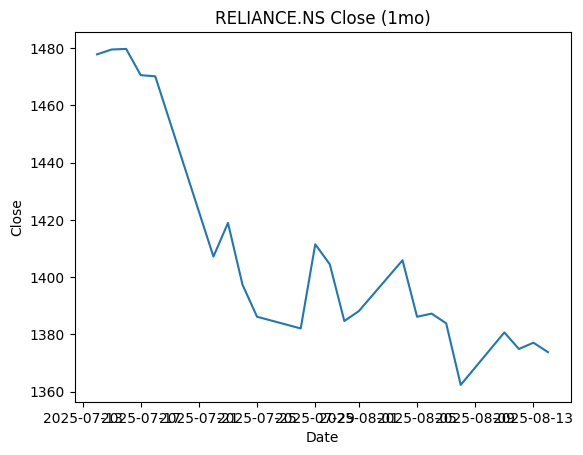

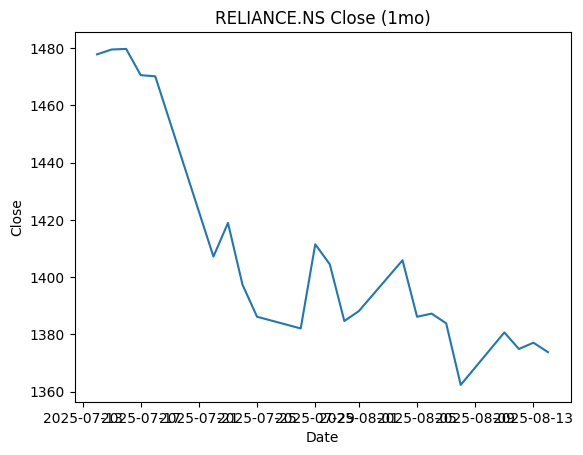

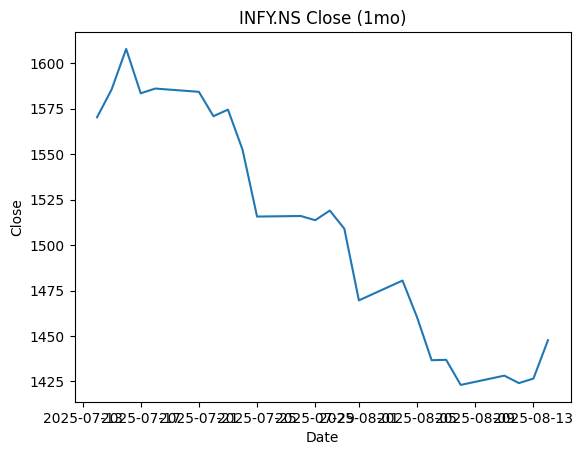

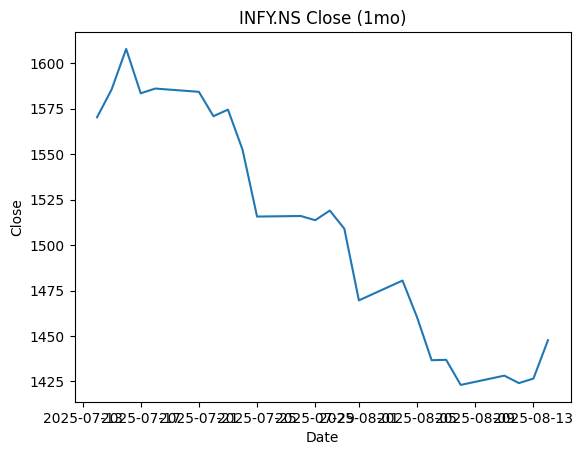

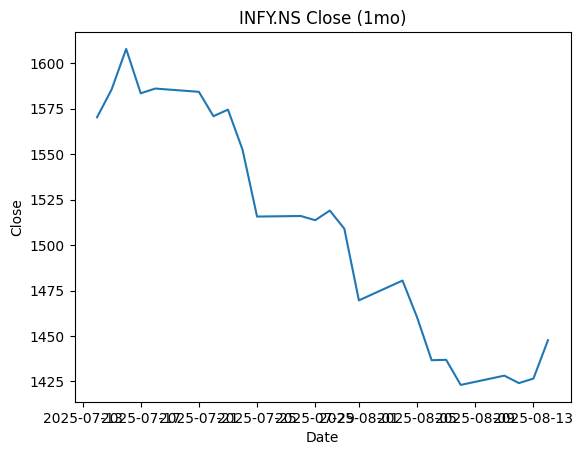

In [33]:
import yfinance as yf
import matplotlib.pyplot as plt

period = w.value  # read the selection from the widget
data = yf.download("INFY.NS", period=period, interval="1d", progress=False, auto_adjust=True)

if not data.empty:
    fig, ax = plt.subplots()
    ax.plot(data.index, data["Close"])
    ax.set_title(f"INFY.NS Close ({period})")
    ax.set_xlabel("Date")
    ax.set_ylabel("Close")
    plt.show()
else:
    print("No price data found.")


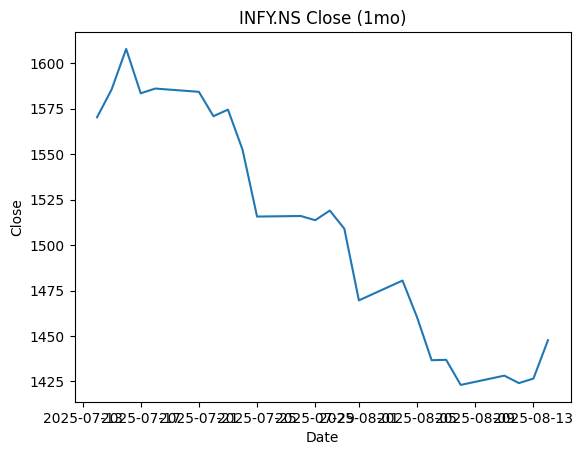

In [34]:
import yfinance as yf
import matplotlib.pyplot as plt

period = w.value  # from your dropdown
data = yf.download("INFY.NS", period=period, interval="1d", progress=False, auto_adjust=True)

if not data.empty:
    fig, ax = plt.subplots()
    ax.plot(data.index, data["Close"])
    ax.set_title(f"INFY.NS Close ({period})")
    ax.set_xlabel("Date")
    ax.set_ylabel("Close")
    plt.show()
else:
    print("No price data found.")


2025-08-14 21:10:13.730 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-14 21:10:13.732 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-14 21:10:13.733 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-14 21:10:13.735 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-14 21:10:13.736 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-14 21:10:13.736 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-14 21:10:13.738 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-14 21:10:14.199 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

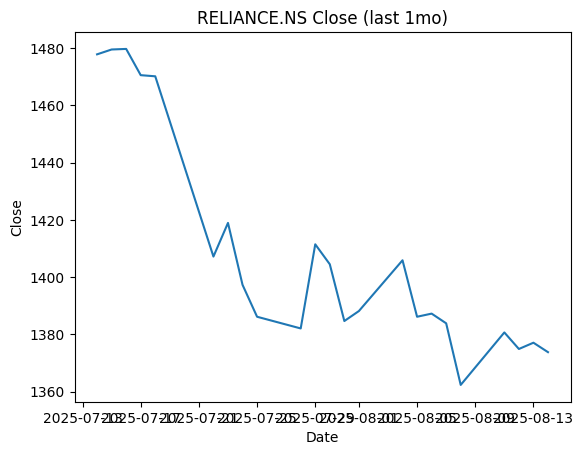

In [35]:
# ---- UI: chart period selector ----
period = st.selectbox(
    "Chart period",
    ["1mo", "3mo", "6mo", "1y"],
    index=0
)

# default ticker for the chart if none typed
chart_ticker = (ticker or "").strip() or "RELIANCE.NS"

# ---- Download prices with the chosen period ----
try:
    data = yf.download(
        chart_ticker,
        period=period,          # <-- use selected period
        interval="1d",
        progress=False,
        auto_adjust=True
    )
    if not data.empty:
        fig, ax = plt.subplots()
        ax.plot(data.index, data["Close"])
        ax.set_title(f"{chart_ticker} Close (last {period})")
        ax.set_xlabel("Date")
        ax.set_ylabel("Close")
        st.pyplot(fig)
    else:
        st.info("No price data found for that ticker.")
except Exception as e:
    st.warning(f"Could not load chart: {e}")


In [37]:
import os, pandas as pd, numpy as np, chromadb, yfinance as yf
from sentence_transformers import SentenceTransformer

BASE = os.path.dirname(os.path.abspath("app.py"))
STORE_DIR = os.path.join(BASE, "vector_store")
COLLECTION = "finance-docs"

client = chromadb.PersistentClient(path=STORE_DIR)
col = client.get_collection(COLLECTION)

try:
    model
except NameError:
    model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

def _normalize_prices(df: pd.DataFrame) -> pd.DataFrame:
    """
    Make yfinance output consistent:
    - Flatten MultiIndex columns (if any)
    - Ensure a 'Date' column exists (from index)
    - Prefer 'Close' (fallback to 'Adj Close' if needed)
    """
    if df is None or len(df) == 0:
        return pd.DataFrame()

    out = df.copy()

    # 1) Flatten multi-index columns (happens sometimes)
    if isinstance(out.columns, pd.MultiIndex):
        out.columns = out.columns.get_level_values(0)

    # 2) Ensure a 'Date' column
    if isinstance(out.index, pd.DatetimeIndex):
        # nicest way to get a 'Date' column with the right name
        out = out.reset_index(names="Date")
    else:
        out = out.reset_index()
        # if yfinance gave us a generic 'index' column, rename it
        if "index" in out.columns:
            out.rename(columns={"index": "Date"}, inplace=True)

    # 3) Make sure Date is datetime and not null
    out["Date"] = pd.to_datetime(out["Date"], errors="coerce")
    out = out.dropna(subset=["Date"])

    # 4) Standardize price columns
    if "Close" not in out.columns and "Adj Close" in out.columns:
        out.rename(columns={"Adj Close": "Close"}, inplace=True)

    # (optional) strip any lingering column name whitespace
    out.columns = [str(c).strip() for c in out.columns]

    return out

def ingest_more(tickers):
    total = 0
    for tkr in tickers:
        # pull last month daily, auto-adjusted
        raw = yf.download(tkr, period="1mo", interval="1d",
                          progress=False, auto_adjust=True)

        df = _normalize_prices(raw)
        if df.empty:
            print(f"Skipping {tkr}: no data.")
            continue

        docs, metas, ids = [], [], []
        for _, r in df.iterrows():
            # format date once it's guaranteed to exist
            d = pd.to_datetime(r["Date"]).strftime("%Y-%m-%d")

            # be defensive about missing columns / types
            o = float(r.get("Open", np.nan))
            h = float(r.get("High", np.nan))
            l = float(r.get("Low",  np.nan))
            c = float(r.get("Close", np.nan))
            v = r.get("Volume", 0)
            try:
                v = int(float(v))
            except Exception:
                v = 0

            docs.append(
                f"On {d}, {tkr} closed at {c:.2f}, opened at {o:.2f}, "
                f"high {h:.2f}, low {l:.2f}, with volume {v}."
            )
            metas.append({"ticker": tkr, "date": d})
            ids.append(f"{tkr}-{d}")

        if not docs:
            print(f"Skipping {tkr}: no rows to ingest.")
            continue

        embs = model.encode(docs, normalize_embeddings=True).tolist()
        col.add(documents=docs, metadatas=metas, ids=ids, embeddings=embs)
        print(f"✅ Ingested {tkr}: {len(docs)} facts")
        total += len(docs)

    print(f"Done. Added {total} facts.")

# --- run ingestion (change or extend this list as you like) ---
ingest_more(["TSLA", "GOOGL", "MSFT"])


✅ Ingested TSLA: 24 facts
✅ Ingested GOOGL: 24 facts
✅ Ingested MSFT: 24 facts
Done. Added 72 facts.


In [38]:
ingest_more(["AAPL", "META", "AMZN"])          # US examples
ingest_more(["INFY.NS", "TCS.NS", "TECHM.NS"]) # NSE examples


✅ Ingested AAPL: 24 facts
✅ Ingested META: 24 facts
✅ Ingested AMZN: 24 facts
Done. Added 72 facts.
✅ Ingested INFY.NS: 24 facts
✅ Ingested TCS.NS: 24 facts
✅ Ingested TECHM.NS: 24 facts
Done. Added 72 facts.
